In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.interpolate import CubicSpline
from scipy import signal
import json
import os
import sklearn

In [ ]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# DATA PREPERATION

Interpolating cross-section data

In [3]:
#with open('D:\\BTP\\temp\\usable_data_generated', 'r') as fout:
#    usable_data_generated = json.load(fout)
    
with open('usable_data', 'r') as fout:
    usable_data = json.load(fout)
    
# usable_data += usable_data_generated

Preparing cross-section data by stacking elastic,ionization and excitation cross sections.

Data is converted into log and then normalize between -1 and 1 using min max

In [4]:
import math

elastic_crosssection = []
ionization_crosssection = []
excitation_crosssection = []
elastic_energy = []
ionization_energy = []
excitation_energy = []

for species in usable_data:   
    elastic_crosssection.append(species['elastic']['crosssection'])
    ionization_crosssection.append(species['ionization']['crosssection'])
    excitation_crosssection.append(species['excitation']['crosssection'])
    elastic_energy.append(species['elastic']['energy'])
    ionization_energy.append(species['ionization']['energy'])
    excitation_energy.append(species['excitation']['energy'])

elastic_crosssection = np.array(elastic_crosssection)
ionization_crosssection = np.array(ionization_crosssection)
excitation_crosssection = np.array(excitation_crosssection)
crosssection_data = np.stack([elastic_crosssection,ionization_crosssection,excitation_crosssection], axis=2)
crosssection_data = np.swapaxes(crosssection_data,1,2)

crosssection_data = crosssection_data + 10**-25
crosssection_data = np.log(crosssection_data)

# Normalizing between -1 and 1 by min max

min_crosssection = np.amin(crosssection_data,axis=(0,2),keepdims=True)

max_crosssection = np.amax(crosssection_data,axis=(0,2),keepdims=True)

crosssection_data = 2*(crosssection_data - min_crosssection)/(max_crosssection - min_crosssection) - 1

# y = 2*(x-min)/(max-min) - 1
# x = (y+1)*(max-min)/2 + min

print("Shape of min_crosssection :",min_crosssection.shape)
print("Shape of max_crosssection :",max_crosssection.shape)
print("Shape of crosssection_data :",crosssection_data.shape)

Shape of min_crosssection : (1, 3, 1)
Shape of max_crosssection : (1, 3, 1)
Shape of crosssection_data : (46, 3, 100)


# WGAN2 FOR GENERATING SPECTOGRAMS

Loading generator1

In [67]:
generator1 = keras.models.load_model('/content/drive/MyDrive/generator_model1_1000epoch/')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
noise_dim = 10
BATCH_SIZE = 10
train_images = crosssection_data[:,0,:]
train_images = train_images.reshape(crosssection_data.shape[0],crosssection_data.shape[2],1)
train_images = train_images.reshape(train_images.shape[0], *(100,1,1)).astype("float32")
np.random.shuffle(train_images)
D = 32
train_images.shape

(46, 100, 1, 1)

In [69]:
def make_discriminator2():
    input_img = layers.Input(shape=(100,1,1))
    
    x = layers.Reshape((100,1))(input_img)
    
    x = layers.Conv1D(D, 5, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv1D(D*2, 5, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv1D(D*4, 5, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv1D(D*8, 5, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv1D(D*16, 5, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    
#     x = layers.Conv1D(D*32, 5, strides=2, padding='same')(x)
#     x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
        
    discriminator2 = keras.models.Model(input_img, x, name="discriminator2")
    return discriminator2

discriminator2 = make_discriminator2()
discriminator2.summary()

Model: "discriminator2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 1, 1)]       0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 50, 32)            192       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 50, 32)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 25, 64)            10304     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 25, 64)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 13, 128)        

In [70]:
D = 16

def make_generator2():
    noise = layers.Input(shape=(50,1,1))
    
    x = layers.Reshape((50,1))(noise)
    
    x = layers.Conv1D(16 * D, 10, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv1D(8 * D, 10, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
        
    x = layers.Conv1D(4 * D, 10, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv1D(2 * D, 10, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv1D(1 , 10, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
        
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(2 * D, 10, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
        
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(4 * D, 10, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Cropping1D(1)(x)
    
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(4 * D, 10, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Cropping1D(1)(x)
    
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(8 * D, 10, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Cropping1D(1)(x)
    
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(1, 10, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("tanh")(x)
    
    x = layers.Reshape((100,1,1))(x)
    
    generator2 = keras.models.Model(noise, x, name="generator2")
    return generator2

generator2 = make_generator2()
generator2.summary()

Model: "generator2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50, 1, 1)]        0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 25, 256)           2816      
_________________________________________________________________
batch_normalization_10 (Batc (None, 25, 256)           1024      
_________________________________________________________________
activation_10 (Activation)   (None, 25, 256)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 13, 128)           327808    
_________________________________________________________________
batch_normalization_11 (Batc (None, 13, 128)           5

In [71]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=5,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = generator1(tf.random.normal(
                shape=(batch_size, self.latent_dim)), training=False)
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = generator1(tf.random.normal(
                shape=(batch_size, self.latent_dim)), training=False)
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [72]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=noise_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = generator1(tf.random.normal(
                shape=(BATCH_SIZE, self.latent_dim)), training=False)
        generated_images = self.model.generator(random_latent_vectors)

        plt.figure()
        for i in range(self.num_img):
            img = generated_images[i].numpy()
            plt.plot(img[:,:,0])
        #plt.savefig("D:\\BTP\\elastic_generated_series\\{epoch}.jpg".format(epoch=epoch))
        plt.close()

In [75]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 1000

# Instantiate the customer `GANMonitor` Keras callback.

## UNCOMMENT FOR COMPLETE CODE
cbk = GANMonitor(num_img=3, latent_dim=noise_dim) 

# Instantiate the WGAN model.
wgan2 = WGAN(
    discriminator=discriminator2,
    generator=generator2,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
)

# Compile the WGAN model.
wgan2.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan2.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/1000
5/5 [==============================] - 24s 98ms/step - d_loss: -0.4132 - g_loss: 0.1989
Epoch 2/1000
5/5 [==============================] - 0s 93ms/step - d_loss: -0.2650 - g_loss: 0.0630
Epoch 3/1000
5/5 [==============================] - 0s 96ms/step - d_loss: -0.4197 - g_loss: 0.1027
Epoch 4/1000
5/5 [==============================] - 0s 93ms/step - d_loss: -0.2385 - g_loss: 0.2446
Epoch 5/1000
5/5 [==============================] - 0s 96ms/step - d_loss: -0.3308 - g_loss: 0.2089
Epoch 6/1000
5/5 [==============================] - 0s 96ms/step - d_loss: -0.2147 - g_loss: 0.1206
Epoch 7/1000
5/5 [==============================] - 0s 98ms/step - d_loss: -0.3354 - g_loss: 0.2146
Epoch 8/1000
5/5 [==============================] - 0s 100ms/step - d_loss: -0.2648 - g_loss: 0.2282
Epoch 9/1000
5/5 [==============================] - 0s 95ms/step - d_loss: -0.2577 - g_loss: 0.0858
Epoch 10/1000
5/5 [==============================] - 0s 98ms/step - d_loss: -0.3641 - g_loss: 0.34

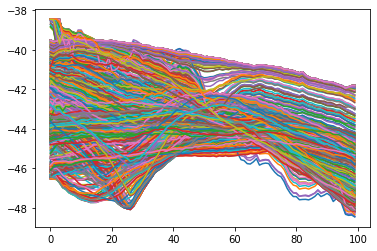

In [76]:
synth_data = []
for i in range(1000):
    x = generator2(generator1(tf.random.normal(shape=(1, noise_dim)), training=False),training=False)
    x = x.numpy()
    x = (x+1)*(max_crosssection[0]-min_crosssection[0])/2 + min_crosssection[0]
    synth_data.append(x[0,:,0,0])
    plt.plot(x[0,:,0,0])

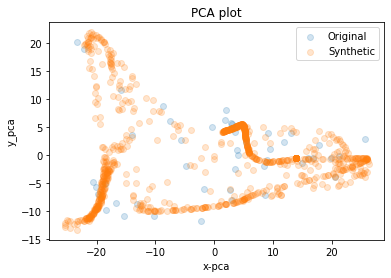

In [63]:
from sklearn.decomposition import PCA

synth_data = np.array(synth_data)
synth_data.shape

elastic_data = (crosssection_data[:,0,:]+1)*(max_crosssection[0][0]-min_crosssection[0][0])/2 + min_crosssection[0][0]
elastic_crosssection = np.log(elastic_crosssection + 10**-25)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(elastic_data)
pca_hat_results = pca.fit_transform(synth_data[:1000])
f, ax = plt.subplots(1)    
plt.scatter(pca_results[:,0], pca_results[:,1], alpha = 0.2, label = "Original")
plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], alpha = 0.2, label = "Synthetic")
ax.legend()  
plt.title('PCA plot')
plt.xlabel('x-pca')
plt.ylabel('y_pca')
plt.show()